This notebook describes how to compute and derive insights from various classification evaluation metrics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### read data & eda

In [3]:
df=pd.read_csv('metrics_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Donated    748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [5]:
df['Donated'].value_counts()

Donated
0    570
1    178
Name: count, dtype: int64

In [7]:
print ('# duplicates label 0:', len(df[(df['Donated']==0) & (df.duplicated())]))
print('# duplicates label 1:',len(df[(df['Donated']==1) & (df.duplicated())]))

# duplicates label 0: 186
# duplicates label 1: 29


In [9]:
# drop duplicates
df= df.drop_duplicates()

In [13]:
df['Donated'].value_counts()

Donated
0    384
1    149
Name: count, dtype: int64

In [11]:
# slightly imbalanced dataset
print('% of label 1 samples: {:.2%}'.format(len(df[df['Donated']==1])/len(df)))
print('% of label 0 samples: {:.2%}'.format(len(df[df['Donated']==0])/len(df)))

% of label 1 samples: 27.95%
% of label 0 samples: 72.05%


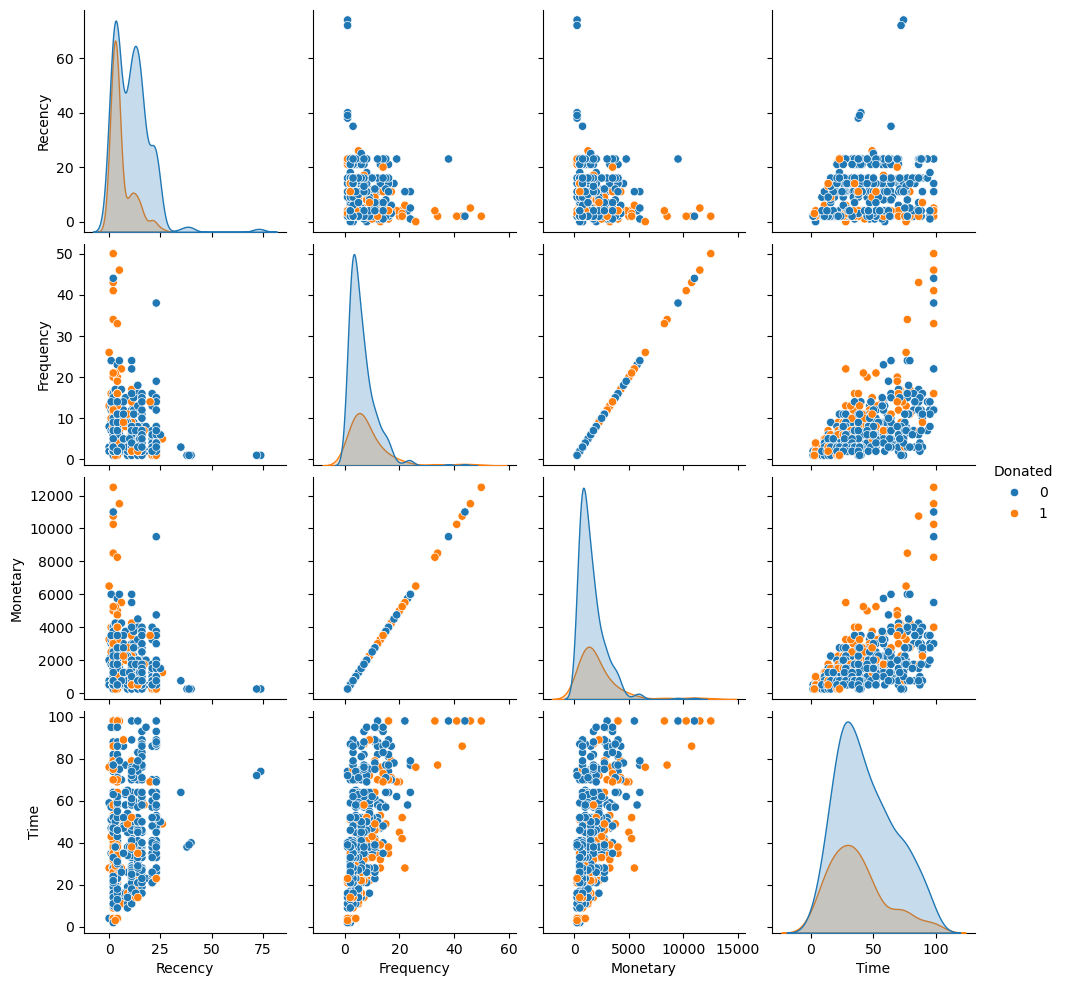

In [15]:
sns.pairplot(df, hue='Donated', diag_kind='kde')

In [17]:
# suspicious correlation. Monetary equals blood donated each time (cc) * Frequency .
(df['Monetary']/df['Frequency']).unique()

array([250.])

In [19]:
# repeated variable must be removed
df=df.drop('Monetary', axis=1)

In [21]:
print('Number of outlier Recency values: ',(df['Recency']>30).sum())

Number of outlier Recency values:  6


In [23]:
# removes rows with outlier recency data
df= df[df['Recency']<30]

In [25]:
# generates new feature, normalizes frequency by number of months since the first donation 
df['Freq_month']=df['Frequency']/df['Time']

In [27]:
df.head()

,Recency,Frequency,Time,Donated,Freq_month
0,2,50,98,1,0.510204
1,0,13,28,1,0.464286
2,1,16,35,1,0.457143
3,2,20,45,1,0.444444
4,1,24,77,0,0.311688


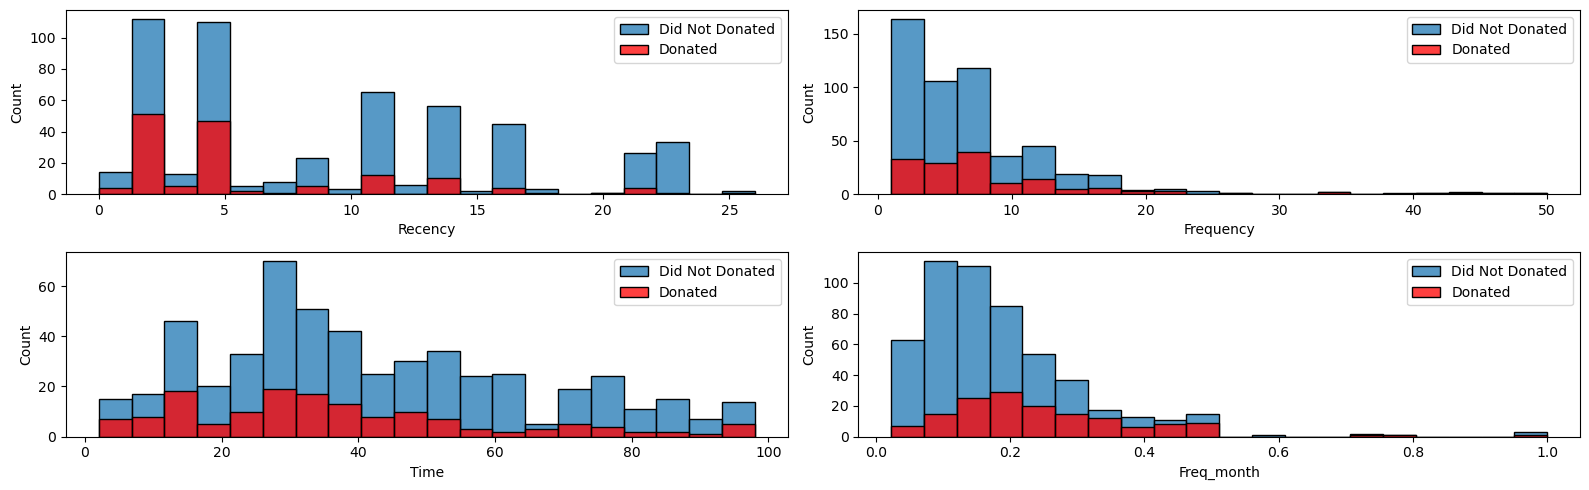

In [29]:
fig, axes= plt.subplots(2,2, figsize=(16,5))
axes=axes.flatten()

for i, col in enumerate (df.drop('Donated', axis=1)):
    sns.histplot(df.loc[:,col], ax=axes[i], bins=20, binrange=[min(df[col]),max(df[col])], label='Did Not Donated')
    sns.histplot(df.loc[df['Donated']==1,col], ax=axes[i], color='red', bins=20, 
                 binrange=[min(df[col]),max(df[col])], label='Donated')
    axes[i].legend()
plt.tight_layout()

C:\Users\AJANTHA\AppData\Local\Temp\ipykernel_3168\2774554450.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Donated',y=col, data=df, palette="Set2", order=[0, 1], ax=axes[i], width=0.6)
C:\Users\AJANTHA\AppData\Local\Temp\ipykernel_3168\2774554450.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Donated',y=col, data=df, palette="Set2", order=[0, 1], ax=axes[i], width=0.6)
C:\Users\AJANTHA\AppData\Local\Temp\ipykernel_3168\2774554450.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Donated',y=col, data=df, palette="Set2",

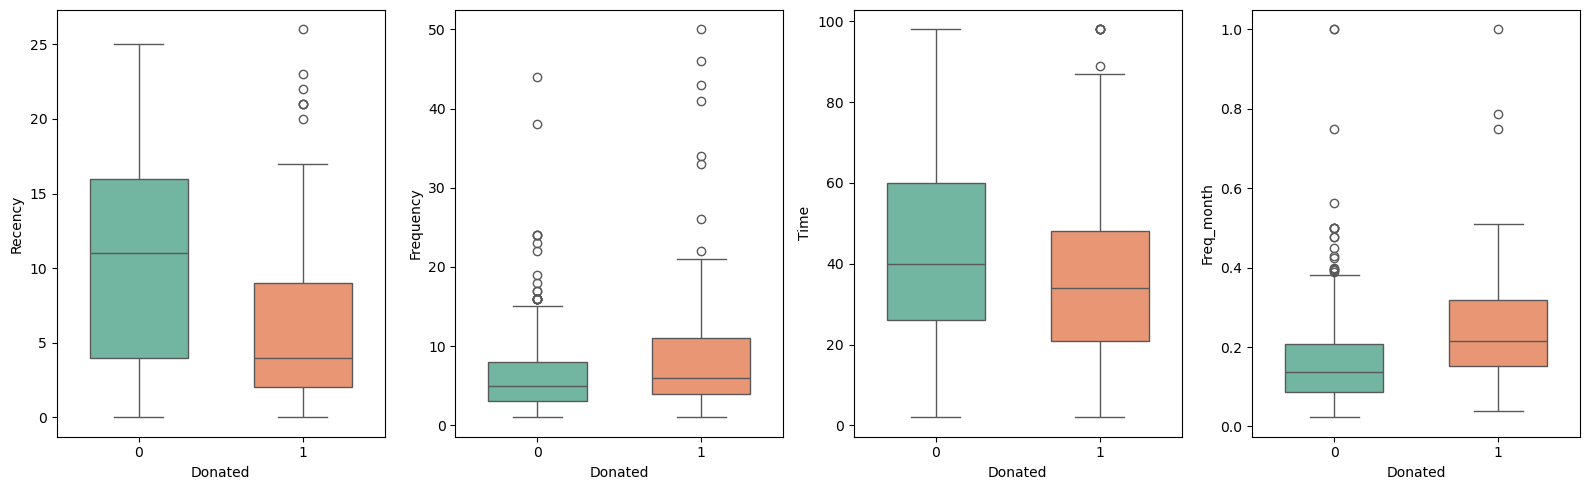

In [31]:
fig, axes= plt.subplots(1,4, figsize=(16,5))

for i, col in enumerate(df.drop('Donated', axis=1)):
    sns.boxplot(x='Donated',y=col, data=df, palette="Set2", order=[0, 1], ax=axes[i], width=0.6)
plt.tight_layout()

### Classification
A KNN classifier was used to predict whether or not a person would donate blood. Please note that default parameters were used without tuning any hyper-parameters in order to stay focused on the metrics topic.

In [33]:
# creates predictors and target datasets
X= df.drop('Donated', axis=1)
y=df['Donated']

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [37]:
# split the data into training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25, stratify=y, random_state=107)

In [39]:
# scale the predictor features based on the training data 
scaler=StandardScaler()
scaler.fit(X_train)

X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [41]:
# fits the model- KNN was used as it is less impacted by imbalnce in the data compared to other classifiers
knn=KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

### 1) Confusion matrix
- A confusion matrixthe represents the number of correct and incorrect predictions broken down by each class.

In [45]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, knn.predict(X_test))

array([[78, 17],
       [26, 11]], dtype=int64)

In [47]:
from imblearn.combine import SMOTETomek

In [49]:
# oversampling the data
smt = SMOTETomek(sampling_strategy='auto', random_state=105)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

C:\Users\AJANTHA\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\AJANTHA\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\AJANTHA\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [51]:
from sklearn.svm import SVC

In [53]:
# fit the model to new datasets
svc=SVC(probability=True)

svc.fit(X_train_smt, y_train_smt)

SVC(probability=True)

In [55]:
confusion_matrix(y_test, svc.predict(X_test))

array([[77, 18],
       [15, 22]], dtype=int64)

### 2) Accuracy
- Although a confusion matrix can provide useful information, looking at and digesting all of the numbers presented in the matrix can sometimes be overwhelming. Confusion matrices can be summarized into a single value metric such as accuracy, recall, or precision.

- Accuracy is defined as the ratio of the number of correctly classified samples to the total number of samples. For a training task, a model accuracy is represented by a single value (unlike other parameters such as precision, recall, and f1-score that are reported for each class using 1 vs. all methodology).

$$Accuracy=TP/(TP+FP+TN+FN)$$

In [57]:
from sklearn.metrics import accuracy_score

print ('Accuracy (imbalanced dataset): {:2.2%}'.format(accuracy_score(y_test, knn.predict(X_test))))
print ('Accuracy (balanced dataset): {:2.2%}'.format(accuracy_score(y_test, svc.predict(X_test))))

Accuracy (imbalanced dataset): 67.42%
Accuracy (balanced dataset): 75.00%


### 3) Recall
- Recall is the proprtion of samples in a class that are correctly predicted.

- If the target class is important in your analysis and you do not want any of the target samples to be classified as non-target class, recall is the metric to focus on as a high recall rate relates to a low false negative rate.
$$Recall=TP/(TP+FN)$$

In [60]:
from sklearn.metrics import recall_score

print ('Recall: {:2.2%}'.format(recall_score(y_test, svc.predict(X_test))))

Recall: 59.46%


###  4) Precision
- Precision is defined by the ratio of predicted positive samples being actually positive. 

- If you don't want a large number of non-target class samples to be classified as target class, precision could be the primary metric for your analysis as high precision relates to a low false positive rate.
$$Precision=TP/(TP+FP)$$

In [63]:
from sklearn.metrics import precision_score

In [65]:
print ('Precision: {:2.2%}'.format(precision_score(y_test, svc.predict(X_test))))

Precision: 55.00%


### 5) f1 score
- Precision and recall can be combined and represented as the f1-score, which is the harmonic average of their values. Both false positive and false negative values are considered to calculate this metric.

In [67]:
from sklearn.metrics import f1_score

In [69]:
print ('f1_score: {:2.2}'.format(f1_score(y_test, svc.predict(X_test))))

f1_score: 0.57


### 6) Precision-recall curve
- There is a trade-off between precision and recall, which means that altering the probability threshold (used to determine the predicted class) increases one parameter while decreasing the other.

- The **precision-recall curve** depicts the trade-off between precision and recall. A large area under the curve indicates that the model has a high recall as well as a high precision.

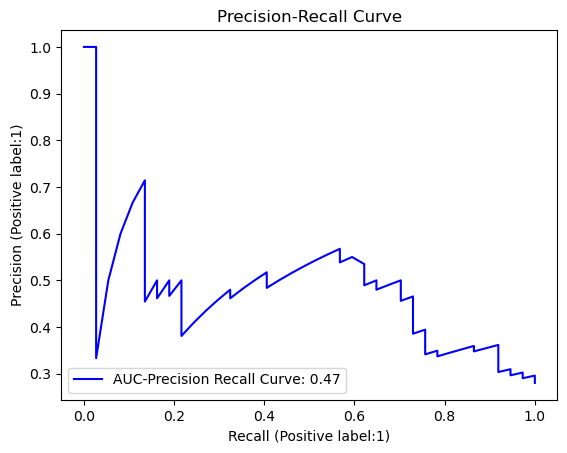

In [71]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, svc.predict_proba(X_test)[:,1])

auc_rp = auc(recall, precision)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue', label="AUC-Precision Recall Curve: {:.2}".format(auc_rp))

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision (Positive label:1)')
ax.set_xlabel('Recall (Positive label:1)')
plt.legend(loc="lower left")
plt.show()

### 7) AUC-ROC score
- The AUC-ROC score, which is calculated using the area under the Receiver Operating Characteristics curve, is one of the most reliable metrics for evaluating a classifier.


- The ROC curve is a graphical representation of a classifier's ability to distinguish between classes at different probability thresholds.


- True Positive rate (which is equivalent to recall: TP/TP+FN) is plotted against False Positive rate (FP/FP+TN) at different probability thresholds to generate a ROC graph.


- The ideal case is for the TP rate to remain high while the FP rate decreases as the threshold rises, resulting in a high AUC value. Using the one vs aLL methodology, we can plot the n number of AUC ROC Curves for n number of classes in a multi-class model.

In [74]:
from sklearn.metrics import roc_curve, roc_auc_score

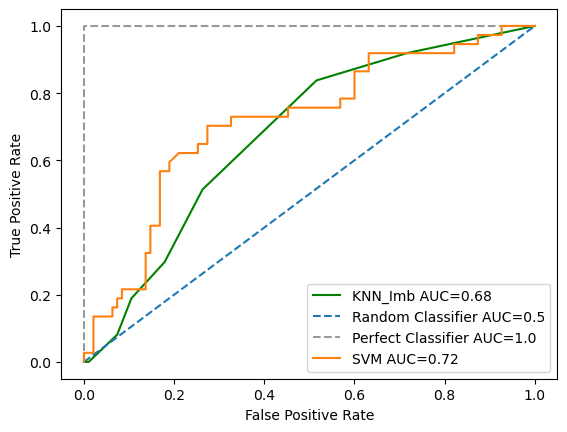

In [76]:
# fpr: false positive rate, tpr=true positive rate
auc_svc = roc_auc_score(y_test, svc.predict_proba(X_test)[:,1])

fpr_svc, tpr_svc, _ = roc_curve(y_test,  svc.predict_proba(X_test)[:,1])

# random classifier. A classifier with no skill. Only predicts 0 for all samples
random_probs = [0 for _ in range(len(y_test))]
auc_random = roc_auc_score(y_test, random_probs)
fpr_rn, tpr_rn, _ = roc_curve(y_test, random_probs)

# classifier trained on imbalanced dataset
auc_knn = roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])

fpr_knn, tpr_knn, _ = roc_curve(y_test,  knn.predict_proba(X_test)[:,1])

# perfect classifier. predicting all samples correctly
auc_perfect = roc_auc_score(y_test, y_test)
fpr_pr, tpr_pr, _ = roc_curve(y_test, y_test)


#create ROC curve
plt.plot(fpr_knn,tpr_knn,label="KNN_Imb AUC={:.2}".format(auc_knn), color='green')
plt.plot(fpr_rn, tpr_rn, linestyle='--', label='Random Classifier AUC={:.2}'.format(auc_random))
plt.plot(fpr_pr, tpr_pr, linestyle='--',color='black', alpha=0.4, label='Perfect Classifier AUC={:.2}'.format(auc_perfect))
plt.plot(fpr_svc,tpr_svc,label="SVM AUC={:.2}".format(auc_svc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()